In [7]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
from graphviz import Digraph

In [40]:
class Value:
    
    
    def __init__(self, value, children = (), op = '', label = ''):
        
        self.data = value 
        self.grad = 0.0
        self._backward = lambda: None
        self.children = set(children)
        self.op = op
        self.label = label
    
    
    def __add__(self, other):
        
        other = other if isinstance(other, Value) else Value(other, label = str(other))
        result = Value(self.data + other.data, (self, other), '+', label = str(self.data + other.data))
        
        def _backward():
            self.grad += 1 * result.grad
            other.grad += 1 * result.grad
        
        result._backward = _backward
        return result
    
    
    def __radd__(self, other):
        
        return self + other
        
    
    def __mul__(self, other):
        
        other = other if isinstance(other, Value) else Value(other, label = str(other))
        result = Value(self.data * other.data, (self, other), '*', label = str(self.data * other.data))
        
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        
        result._backward = _backward
        return result
    
    
    def __rmul__(self, other):
        
        return self * other
    
    
    def __neg__(self): # -self
        
        return self * -1

    def __sub__(self, other): # self - other
        
        return self + (-other)

    
    def __rsub__(self, other):
        
        return self + (-other)
    
    
    def __pow__(self, other):
        
        assert isinstance(other, (float, int)), "only floats or ints in pow"
        result = Value(self.data ** other, (self,), f'**{other}', label = str(self.data ** other))
        
        def _backward():
            self.grad += (other * (self.data ** (other - 1) ) ) * result.grad 
        
        result._backward = _backward
        return result
    
    
    def tanh(self):
        
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        result = Value(t, (self, ), 'tanh', label = str(t))
        
        def _backward():
            self.grad += (1 - t**2) * result.grad
        
        result._backward = _backward
        return result
    
    
    def exp(self):
        
        e_x = math.exp(self.data)
        result = Value(e_x, (self,), 'exp', label = str(e_x) )
        
        def _backward():
            self.grad += e_x * result.grad
        
        result._backward = _backward
        return result
    
    
    
    def __repr__(self):
        
        return f"Value({self.data})"
    
    
    def backward(self):
        
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                
                for child in v.children:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
    
        

In [2]:
def trace(root):
    
    nodes, edges = set(), set()
    
    def build(v):
        
        if v not in nodes:
            nodes.add(v)
        
        for child in v.children:
            edges.add( (child, v) )
            build(child)
    
    build(root)
    return nodes, edges

In [3]:
def draw_dot(root):
    
    graph = Digraph(graph_attr = {'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for node in nodes:
        uid = str( id(node) )
        graph.node(name = uid, label = f"data: {node.label} | grad: {node.grad}", shape = 'record')
        
        if node.op:
            graph.node(name = uid + node.op, label = node.op)
            graph.edge(uid + node.op, uid)
    
    for n1, n2 in edges:
        uid1 = str( id(n1) )
        uid2 = str( id(n2) )
        graph.edge(uid1, uid2 + n2.op)
    
    return graph

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o._backward()

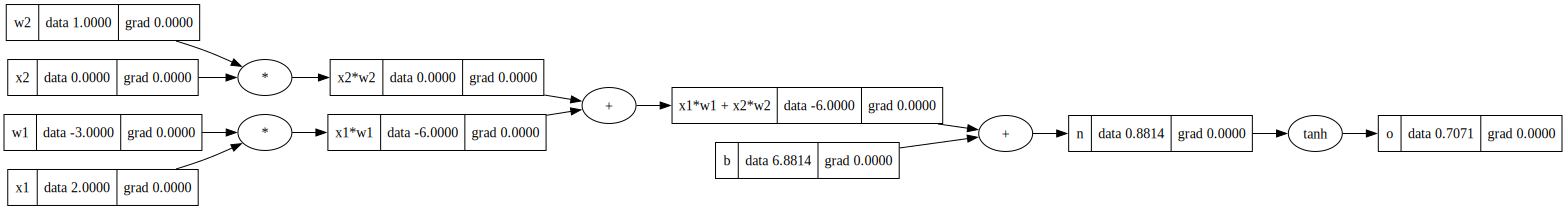

In [42]:
draw_dot(o)